# Predictions on different data quality

## Parameters and model

In [1]:
import sys

sys.path.append('..')
from timeseries.timeseries import StockMarketSeries
from timeseries.utils import SeriesColumn, DeviationSource
from predictions.model import PredictionModel

company_name = "Adobe"
time_series_start = "2017-01-03"
time_series_values = 300
column = SeriesColumn.CLOSE
stock = StockMarketSeries(company_name, time_series_start, time_series_values,
                           weights={SeriesColumn.OPEN: 0.2,
                                    SeriesColumn.CLOSE: 0.2,
                                    SeriesColumn.ADJ_CLOSE: 0.25,
                                    SeriesColumn.HIGH: 0.15,
                                    SeriesColumn.LOW: 0.15,
                                    SeriesColumn.VOLUME: 0.05})

## Data - one price column

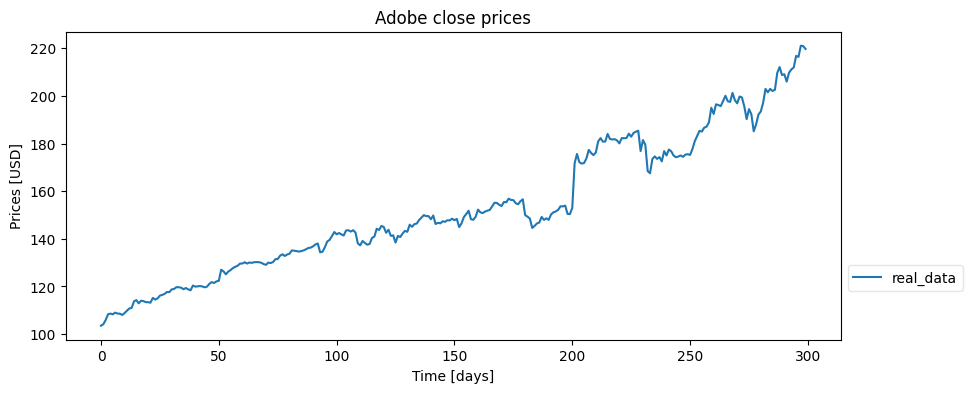

In [2]:
stock.plot_series("close prices", real_data=stock.real_series[SeriesColumn.CLOSE])

## Predictions parameters

In [8]:
prediction_start = 250
iterations = 3

model = PredictionModel(stock, prediction_start, column, iterations=iterations)

## Statistical methods

In [9]:
from arima import ManualArima

arima_type = ManualArima

## AR(5)

In [10]:
arima = model.configure_model(arima_type, p=5, q=0)

C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\predictio

In [11]:
%%capture --no-stdout --no-display
arima.plot_prediction(source=DeviationSource.NONE)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [12]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

## ARIMA(5,1,5)

In [ ]:
arima = model.configure_model(arima_type, p=5, q=2)

In [ ]:
%%capture --no-stdout --no-display
arima.plot_prediction(source=DeviationSource.NONE)

In [ ]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

## XGBoost

In [ ]:
from ml import XGBoost

xgboost = model.configure_model(XGBoost, optimize=False)

In [ ]:
xgboost.plot_prediction(source=DeviationSource.NONE)

In [ ]:
%%capture --no-stdout --no-display
xgboost.compute_statistics_set()

## Reservoir computing

In [ ]:
from predictions.ml import Reservoir

reservoir = model.configure_model(Reservoir)

In [ ]:
reservoir.plot_prediction(source=DeviationSource.NONE)

In [ ]:
%%capture --no-stdout --no-display
reservoir.compute_statistics_set()